Install the required packages

In [7]:
## If you are using pip to manage your environment
#pip install requests beautifulsoup4 numpy altair plotnine tqdm pillow matplotlib

## or if you are using conda to manage your environment
# %conda install requests beautifulsoup4 numpy altair plotnine tqdm pillow matplotlib

In [8]:
pip install altair

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/731.2 kB ? eta -:--:--
   ---------------------------------------- 731.2/731.2 kB 6.7 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


Import packages

In [33]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import altair as alt
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import time
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


<a href="https://colab.research.google.com/github/fm-ds/ScrapingWorkshop/blob/main/Scraping.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web Scraping

This notebook introduces web scraping with the `requests` and `BeautifulSoup` modules using the scraping of a British retailer, M&S, as an example.
First, scraping is demonstrated on some very simple HTML, then we will move to the real website.


<br>
<br>

# A Basic Example
## 1. Searching HTML with `BeautifulSoup`

BeautifulSoup is a Python library for parsing HTML documents. We can use it to extract data from HTML we fetch from the web but first we'll try it out with a simple HTML example.

In [57]:
sample_html = """
<html>
<body>
    <h1> BeautifulSoup </h1>
    <p> BeautifulSoup is a Python library for parsing HTML documents. We can use it to extract data from HTML we fetch
        from the web.
        Here, we're just using it to parse some simple sample HTML. </p>

    <h2 class="important"> Searching the tree </h2>
    <p id="searching_description" style="color: red"> BeautifulSoup allows us to search the HTML tree in lots of different ways: by tag, by
        id, by CSS class, and so on. </p>
    <ol>
        <li role="example_1"> By tag: we could search for every li </li>
        <li role="example_2"> By id: we could search for the p tag with id="searching_description" </li>
        <li role="example_3" class="important"> By class: we could search for every tag with a given class </li>
        <li> and so on... </li>
    </ol>
    <div>
        <p>Div tags are used to group block-elements and structure the web page.</p>
    </div>
<body>
</html>
"""

<div class="alert alert-block alert-info">
<h4>HTML cheatsheet: Tags & Attributes</h4>

An HTML element is a part of an HTML document that is made up of a start tag, some content, and then a closing tag: `<div>Some text about anything</div>`. These elements can also include attributes, which go in the start tag: `<div id="unique_abc">Some text</div>`.

<br>

**Tags** are the building blocks of HTML. They are used to define the structure and content of a web page. In the **`sample_html`**, **html**, **body**, **h1**, **p**, **h2**, **ol**, **li**, and **div** are examples of tags. Tags are open 
- `<html>`: The root element that defines the whole HTML document.
- `<body>`: Contains the content of an HTML document.
- `<h1>`, `<h2>`: Heading tags used to define headings. `<h1>` represents the main heading, while `<h2>` represents a subheading (heading tags go all the way down to <b>h6</b>, which is the smallest heading).
- `<p>`: Defines a paragraph.
- `<ol>`: Defines an ordered list.
- `<li>`: Defines a list item within a list.
- `<div>`: A block-level element used as a container to group and style sections of HTML documents with CSS or manipulate them with JavaScript.

<br>

**Attributes** provide additional information about an element's properties. They are always specified in the start tag of an element and usually come in name/value pairs like name="value". Common tags include:
- `class`: An attribute used to specify a class name for an element. It is used by CSS and JavaScript to perform certain tasks for elements with the specified class name.
- `id`: An attribute used to specify a unique id for an element. It is used to identify a single element in the document. In the sample, `id="searching_description"` is used to uniquely identify a paragraph.
- `style`: Defines the inline CSS style for an element. For example, `style="color: red"` changes the text colour of the element to red.
</div>

<br>
<br>

At present the `sample_html` is just a string. In order to search through it, we'll create a Soup object with beautifulSoup - a searchable object representation. 

In [58]:
soup = BeautifulSoup(sample_html, 'html.parser') # Parsing the HTML using BeautifulSoup and the built-in HTML parser 
soup.prettify()
# print(soup.prettify())      # Print the HTML in a nicely formatted way (with indentation)

'<html>\n <body>\n  <h1>\n   BeautifulSoup\n  </h1>\n  <p>\n   BeautifulSoup is a Python library for parsing HTML documents. We can use it to extract data from HTML we fetch\n        from the web.\n        Here, we\'re just using it to parse some simple sample HTML.\n  </p>\n  <h2 class="important">\n   Searching the tree\n  </h2>\n  <p id="searching_description" style="color: red">\n   BeautifulSoup allows us to search the HTML tree in lots of different ways: by tag, by\n        id, by CSS class, and so on.\n  </p>\n  <ol>\n   <li role="example_1">\n    By tag: we could search for every li\n   </li>\n   <li role="example_2">\n    By id: we could search for the p tag with id="searching_description"\n   </li>\n   <li class="important" role="example_3">\n    By class: we could search for every tag with a given class\n   </li>\n   <li>\n    and so on...\n   </li>\n  </ol>\n  <div>\n   <p>\n    Div tags are used to group block-elements and structure the web page.\n   </p>\n  </div>\n  <bod

<br>

We can now search the `soup` object to extract useful information. Let's try searching by tag, attribute, and by both.

Useful BeautifulSoup methods include:
- `find()`: Searches for the first tag that matches a given name or filter, returning a single result.
- `find_all()`: Searches for all tags that match a given name or filter, returning a list of results.
- `get_text()`: Extracts all text from a tag and its children, returning a single string (`.text` also achieves this).
- `get()`: Retrieves the value of a tag attribute, such as "href" in an `<a>` tag or "src" in an `<img>` tag.

<br>

**First, by tag:** Here's an example of using .find() to find the first `<p>` tag:

In [59]:
# Finding the first occurrence of the <p> tag
first_p_tag = soup.find('p')
print(first_p_tag.get_text())

 BeautifulSoup is a Python library for parsing HTML documents. We can use it to extract data from HTML we fetch
        from the web.
        Here, we're just using it to parse some simple sample HTML. 


What if we want to find the text of every list (`<li>`) element on the page? We can use `find_all()`

In [60]:
list_elements = soup.find_all('li') # Finding all the list elements in the HTML
for element in list_elements:
    print(element.text) # Printing the text of each list element

 By tag: we could search for every li 
 By id: we could search for the p tag with id="searching_description" 
 By class: we could search for every tag with a given class 
 and so on... 


**Next, by id** let's find what the paragraph (`<p>`) with the `id` `searching_description` says and let's also take a look at its style.

In [61]:
# instead of using find_all, we can use find to find the first element that matches the search criteria
description_element = soup.find('p', {'id': 'searching_description'}) # Finding the paragraph with id="searching_description"
description_element

print('text:', description_element.text) # Printing the text of the paragraph with id="searching_description"
print('style:', description_element['style']) # Printing the value of the style attribute of the paragraph with id="searching_description"

text:  BeautifulSoup allows us to search the HTML tree in lots of different ways: by tag, by
        id, by CSS class, and so on. 
style: color: red


**by class:** let's find all elements with the `class` `important`

In [62]:
soup.find_all(class_ ='important')

[<h2 class="important"> Searching the tree </h2>,
 <li class="important" role="example_3"> By class: we could search for every tag with a given class </li>]

In [63]:
important_elements = soup.find_all(class_='important') # Finding all the elements with class="important"
print(f"There are {len(important_elements)} elements with class='important'")
for element in important_elements:
    print(element) # Printing each element with class="important"

There are 2 elements with class='important'
<h2 class="important"> Searching the tree </h2>
<li class="important" role="example_3"> By class: we could search for every tag with a given class </li>


**finally**, we can search in any way we want by supplying a function of our own 

let's write a simple function that identifies whether an element's `role` attribute that starts with `example_`

In [64]:
def important_role(role_attribute):
    return role_attribute != None and 'example_' in role_attribute

# Find the first <ol> element
ol_element = soup.find('ol')
ol_element.find_all('li', role=important_role) # Finding all the list elements with a role attribute that contains 'example-'

[<li role="example_1"> By tag: we could search for every li </li>,
 <li role="example_2"> By id: we could search for the p tag with id="searching_description" </li>,
 <li class="important" role="example_3"> By class: we could search for every tag with a given class </li>]

<br>
<br>

## 2. Getting HTML from the web with `Requests`

<div style="display: flex; align-items: flex-start;">
    <div style="flex: 0 2 auto;">
        <img src="https://raw.githubusercontent.com/FM-ds/ScrapingWorkshop/main/notebook_images/sample_html_safari.png" width="400px">
    </div>
    <div style="flex: 1 1 auto; margin-top: 10px; margin-right: 150px">
        <p>We just extracted information from HTML which was defined locally in a string <code>sample_html</code>. Usually, we care about HTML found on the internet. As a simple example, the page defined in <code>sample_html</code> is available at <a href="http://www.fmcevoy.io/ScrapingWorkshop/sample_html">http://www.fmcevoy.io/ScrapingWorkshop/sample_html</a></p>
        <p>To download HTML (and any other resources) from the internet, we can use the <code>requests</code> module.</p>
    </div>
</div>


In [65]:
req = requests.get('http://www.fmcevoy.io/ScrapingWorkshop/sample_html') # Making a request for the sample HTML hosted on the web
req.text # looking at the text of the response

'<html>\n<body>\n    <h1> BeautifulSoup </h1>\n    <p> BeautifulSoup is a Python library for parsing HTML documents. We can use it to extract data from HTML we fetch\n        from the web.\n        Here, we\'re just using it to parse some simple sample HTML. </p>\n\n    <h2 class="important"> Searching the tree </h2>\n    <p id="searching_description" style="color: red"> BeautifulSoup allows us to search the HTML tree in lots of different ways: by tag, by\n        id, by CSS class, and so on. </p>\n    <ol>\n        <li role="example_1"> By tag: we could search for every li </li>\n        <li role="example_2"> By id: we could search for the p tag with id="searching_description" </li>\n        <li role="example_3" class="important"> By class: we could search for every tag with a given class </li>\n        <li> and so on... </li>\n    </ol>\n    <div>\n        <p>Div tags are used to group block-elements and structure the web page.</p>\n    </div>\n\n    <br>\n    <br>\n\n\n    <h3 style

We can then make a traversable `soup` object using the response and search as we did before.

In [66]:
soup = BeautifulSoup(req.text, 'html.parser') # Instead of using the sample HTML, we're using the HTML from the web that we fetched in the previous step
soup.find_all('li') # Finding all the list elements in the HTML

[<li role="example_1"> By tag: we could search for every li </li>,
 <li role="example_2"> By id: we could search for the p tag with id="searching_description" </li>,
 <li class="important" role="example_3"> By class: we could search for every tag with a given class </li>,
 <li> and so on... </li>,
 <li><a href="https://example.com/page1">Page 1</a></li>,
 <li><a href="https://example.com/page2">Page 2</a></li>,
 <li><a href="https://example.com/page3">Page 3</a></li>]

#### <font color='Green'><strong>Exercises: </strong></font> 

**EX 1** Retrieve the text of the paragraph (`<p>`) with the id "exercise1".

In [ ]:
### 1. Add Solution Here ###

ex1 = soup.find('p', {'id': 'exercise1'}) 

print(ex1.get_text())

<p id="exercise1">Find the text of the first paragraph inside this div.</p>
Find the text of the first paragraph inside this div.


**EX 2** Count the number of `<div>` elements on the page that have the class "exercise".

In [69]:
### 2. Add Solution Here ###

ex2 = soup.find_all('div', class_='exercise')
print(len(ex2))

3


**EX 3** Extract and print all the URLs from the anchor (`<a>`) tags within the list in div with the id "exercise3".

In [83]:
### 3. Add Solution Here ###
ex3 = soup.find('div', {'id' : 'exercise3'})
list_items = ex3.find_all('li')

for item in list_items:
    print(item.find('a')['href'])

https://example.com/page1
https://example.com/page2
https://example.com/page3


<br>

---

<br>

# A Useful Example: Scraping Prices from M&S

<div style="display: flex; align-items: flex-start;">
    <div style="flex: 0 1.75 auto; ">
        <img src="https://raw.githubusercontent.com/FM-ds/ScrapingWorkshop/main/notebook_images/ms_plants.png" width="500px">
    </div>
    <div style="flex: 1 1 auto; margin-top: 10px; margin-right: 150px">
        Scraping the sample html is a basic introduction. Let's move to collecting some real-world data.

Marks and Spencers is a high-end British supermarket. Let's see if we can collect prices from one of their pages. Josh and I scrape around 100K prices every day to investigate inflation but there are lots of other uses for this data as well:

- **Price Comparisons**: You could make a supermarket vs supermarket price comparison tool
- **Market Research**: Maybe you want to investigate pricing of your competitors
- **Procurement**: Waiting for sales to emerge

Today, we'll try scraping prices from just one page, Marks and Spencers' plants: https://www.marksandspencer.com/l/flowers-and-plants/plants?sort=best_seller+desc 
    </div>
</div>




## Identifying Structure with Inspect Element

Before we write any code, we should use inspect element to see how prices, pictures and more are defined in the HTML.

<img src="https://raw.githubusercontent.com/FM-ds/ScrapingWorkshop/main/notebook_images/ms_inspect_element.png" width="800vw">

There are lots of elements and intimidating details but here we can see:

- Product Details are contained in `<div>` elements with a `data-tagg` attribute that starts with `product-card-`
- Product Titles are found in `<h2>` elements within the `product-card-` divs

We can also see that the `<a>` tag (a link) has the `aria-label` defined. The `aria-label` is part of the ARIA standard (Accessible Rich Internet Applications) which helps make websites more accessible. We can use this description for our own benefit though.


## Extracting Product Info

First, we'll download the HTML from the M&S site and then we'll search for all the product cards to find their titles.

In [103]:
url = "https://www.marksandspencer.com/l/flowers-and-plants/plants?sort=best_seller+desc"
req = requests.get(url) # Making a request for the M&S plants page
soup = BeautifulSoup(req.text, 'html.parser') # Parsing the HTML using BeautifulSoup and the built-in HTML parser

In [104]:
with open("M&S_plants.html", "w") as file:
    file.write(soup.prettify()) # Writing the prettified HTML to a file

UnicodeEncodeError: 'charmap' codec can't encode character '\u010d' in position 291328: character maps to <undefined>

### Product Titles

Let's try and find all the `product-card-` divs and then look for the `<a>` with the aria label in each one.

First we'll build a list of all divs that contain product details by searching for all elements with the data-tagg attribute that contain "product-card".

For each of these product divs, we'll then search for the `<a>` tag with the `aria-label` attribute, the first `<a>` tag in each `product-card-` `div`.

In [105]:
# find all divs with data-tagg attribute that contain "product-card" and potentially other values
product_divs = soup.find_all('div', attrs={'data-tagg': lambda x: x and "product-card" in x}) # Using a lambda function to find all divs with data-tagg attribute that contain "product-card" and potentially other values
for product_div in product_divs[:10]: # Looping through the first 10 product divs
    a_tag = product_div.find('a') # Finding the first a tag in the product div
    # get the aria-label attribute of the a tag
    aria_label = a_tag['aria-label'] # Getting the value of the aria-label attribute of the a tag
    print(aria_label) # Printing the value of the aria-label attribute of the a tag


Product name is Rose Trough, Product brand is M&S Collection, Price is £25, Rating is 4.5168 out of 5
Product name is Oriental Lily, Product brand is M&S Collection, Price is £28, Rating is 4.6421 out of 5
Product name is Yellow Miniature Phalaenopsis Orchid in Ceramic Pot, Product brand is M&S Collection, Price is £20, Rating is 4.6731 out of 5
Product name is Rose Plant with Marc De Champagne Truffles, Product brand is M&S Collection, Price is £30, Rating is 4.5821 out of 5
Product name is Spring Flowering Basket, Product brand is M&S Collection, Price is £35, Rating is 4.4146 out of 5
Product name is Stephanotis Hoop in Ceramic Pot, Product brand is M&S Collection, Price is £40, Rating is 5 out of 5
Product name is Miniature Pink Orchid with Marc de Champagne Truffles, Product brand is M&S Collection, Price is £25, Rating is 4.7778 out of 5
Product name is Minature Twin-Stem Phaelanopsis Orchid in Ceramic with Marc du Champagne Truffles 125g Bundle, Product brand is M&S Collection, 

We can easily extract product details right from these accesibility labels. Let's write a function to do so.

In [106]:
def product_details_from_label(label):
    # split the label into its parts
    parts = label.split(",") # Splitting the label into its parts

    product_details = {} # Creating an empty dictionary to store the product details
    # each part can do something different, let's loop through the parts in order to find out the name, price, details and rating
    for part in parts:
        if "Product name is " in part:
            product_details['name'] = part.replace("Product name is ", "")
        elif "Price is £" in part:
            product_details['price'] = part.replace("Price is £", "")
        elif "Rating is " in part:
            product_details['rating'] = part.replace("Rating is ", "").replace(" out of 5", "") # keeping just the rating itself
        elif "Product is " in part: # captures stuff like Free delivery
            product_details['details'] = part.replace("Product is ", "")
    return product_details # Returning the product details dictionary

test_details = "Product name is Oriental Lily, Price is £25, Product is Free Delivery, Rating is 4.64 out of 5"
product_details_from_label(test_details) # Testing the function with a sample label
        

{'name': 'Oriental Lily',
 'price': ' 25',
 'details': ' Free Delivery',
 'rating': ' 4.64'}

We can now use our function `product_details_from_label` to go from the accesibility labels ("Product name is...") to structured product information.

In [107]:
products = [] # Creating an empty list to store the product details

# find all divs with data-tagg attribute that contain "product-card" and potentially other values
product_divs = soup.find_all('div', attrs={'data-tagg': lambda x: x and "product-card" in x}) # Using a lambda function to find all divs with data-tagg attribute that contain "product-card" and potentially other values
for product_div in product_divs: # Looping through the first 10 product divs
    a_tag = product_div.find('a') # Finding the first a tag in the product div
    aria_label = a_tag['aria-label'] # Getting the value of the aria-label attribute of the a tag

    product_details = product_details_from_label(aria_label) # Using the function to get the product details from the aria-label
    products.append(product_details) # Appending the product details to the list of products

products[:5] # let's take a peek at the first 5 products

[{'name': 'Rose Trough', 'price': ' 25', 'rating': ' 4.5168'},
 {'name': 'Oriental Lily', 'price': ' 28', 'rating': ' 4.6421'},
 {'name': 'Yellow Miniature Phalaenopsis Orchid in Ceramic Pot',
  'price': ' 20',
  'rating': ' 4.6731'},
 {'name': 'Rose Plant with Marc De Champagne Truffles',
  'price': ' 30',
  'rating': ' 4.5821'},
 {'name': 'Spring Flowering Basket', 'price': ' 35', 'rating': ' 4.4146'}]

## Finding more product information: rank, image and link 

This is a good start but we probably want more information about each product than just names, prices and ratings.

One useful bit of information is just the products rank on the page (products are sorted by `best sellers`). Thankfully this is easy, the `divs` position in `product_divs` is its rank.

We also want to get the urls of images and the product pages.

### Images
Images are easy to find. We'll just look for `img` tags within the `divs`.

<img src="https://raw.githubusercontent.com/FM-ds/ScrapingWorkshop/main/notebook_images/ms_inspect_image.png" width="600">


### Links
The links are also easy. We can just look at the `href` attribute of the `a` tag.




In [108]:
products = [] # Creating an empty list to store the product details

# find all divs with data-tagg attribute that contain "product-card" and potentially other values
product_divs = soup.find_all('div', attrs={'data-tagg': lambda x: x and "product-card" in x}) # Using a lambda function to find all divs with data-tagg attribute that contain "product-card" and potentially other values
for i, product_div in enumerate(product_divs): # Looping through the first 10 product divs
    a_tag = product_div.find('a') # Finding the first a tag in the product div
    aria_label = a_tag['aria-label'] # Getting the value of the aria-label attribute of the a tag

    # extract names, prices, details and ratings from the aria-label
    product_details = product_details_from_label(aria_label) # Using the function to get the product details from the aria-label

    # extract the product link from the a tag
    product_details['url'] = a_tag['href'] # Getting the value of the href attribute of the a tag
    product_details['url'] = "http://www.marksandspencer.com" + product_details['url'] # Adding the base URL to the product URL


    # extract the image link from the a tag
    img_tags = a_tag.find_all('img') # Finding the first img tag in the a tag
    product_details['image'] = img_tags[-1]['src'] # Getting the value of the src attribute of the img tag

    # add the rank of the product
    product_details['rank'] = i + 1 # Adding the rank of the product

    products.append(product_details) # Appending the product details to the list of products


products[:2] # let's take a peek at the first 2 products

[{'name': 'Rose Trough',
  'price': ' 25',
  'rating': ' 4.5168',
  'url': 'http://www.marksandspencer.com/yellow-rose-trough/p/flp21035215#intid=pid_pg1pip44g2r1c1',
  'image': 'https://assets.digitalcontent.marksandspencer.app/image/upload/w_1024,q_auto,f_auto/SD_FD_F44A_00457873_NC_X_EC_90',
  'rank': 1},
 {'name': 'Oriental Lily',
  'price': ' 28',
  'rating': ' 4.6421',
  'url': 'http://www.marksandspencer.com/oriental-lily/p/flp21037669#intid=pid_pg1pip44g2r1c2',
  'image': 'https://assets.digitalcontent.marksandspencer.app/image/upload/w_1024,q_auto,f_auto/SD_FD_F44A_00557771_NC_X_EC_90',
  'rank': 2}]

In [109]:
img_tags

[<img alt="Cascaded Orchid with Champagne &amp; Scented Candle" class="image-with-sizing_image__p4cYU product-image-hover_primary__TfBgH" data-nimg="1" data-tagg="product-image-P60751336" decoding="async" height="500" loading="lazy" sizes="(min-width: 768px) 20vw, 30vw" src="https://assets.digitalcontent.marksandspencer.app/image/upload/w_1024,q_auto,f_auto/SD_FD_F44A_29461660_NC_X_EC_0" srcset="https://assets.digitalcontent.marksandspencer.app/image/upload/w_128,q_auto,f_auto/SD_FD_F44A_29461660_NC_X_EC_0 128w, https://assets.digitalcontent.marksandspencer.app/image/upload/w_256,q_auto,f_auto/SD_FD_F44A_29461660_NC_X_EC_0 256w, https://assets.digitalcontent.marksandspencer.app/image/upload/w_384,q_auto,f_auto/SD_FD_F44A_29461660_NC_X_EC_0 384w, https://assets.digitalcontent.marksandspencer.app/image/upload/w_640,q_auto,f_auto/SD_FD_F44A_29461660_NC_X_EC_0 640w, https://assets.digitalcontent.marksandspencer.app/image/upload/w_768,q_auto,f_auto/SD_FD_F44A_29461660_NC_X_EC_0 768w, https:

# Saving and Visualising 

We now have structured product information in `products`, a list of dicts. Let's bring them into a `pandas` dataframe and start to clean the data ready for visualisation.

The only things we have to do are make our `price`, `rating` and `rank` columns numbers.

In [110]:
df = pd.DataFrame(products) # Creating a DataFrame from the list of products

# make the numeric columns actually numeric
df['price'] = pd.to_numeric(df['price'])
df['rating'] = pd.to_numeric(df['rating'])
df['rank'] = pd.to_numeric(df['rank'])

df = df.dropna(subset=['price', 'rating']) # Dropping rows with missing values in the price and rating columns

df.head() # let's take a peek at the first 5 products

,name,price,rating,url,image,rank
0,Rose Trough,25,4.5168,http://www.marksandspencer.com/yellow-rose-tro...,https://assets.digitalcontent.marksandspencer....,1
1,Oriental Lily,28,4.6421,http://www.marksandspencer.com/oriental-lily/p...,https://assets.digitalcontent.marksandspencer....,2
2,Yellow Miniature Phalaenopsis Orchid in Cerami...,20,4.6731,http://www.marksandspencer.com/yellow-miniatur...,https://assets.digitalcontent.marksandspencer....,3
3,Rose Plant with Marc De Champagne Truffles,30,4.5821,http://www.marksandspencer.com/rose-plant-with...,https://assets.digitalcontent.marksandspencer....,4
4,Spring Flowering Basket,35,4.4146,http://www.marksandspencer.com/summer-flowerin...,https://assets.digitalcontent.marksandspencer....,5


Let's start to take a look at our data.

Let's try some simple scatters with plotnine. 

First, are higher rated products better selling (rank)?

c:\Users\jarem\AppData\Local\Programs\Python\Python313\Lib\site-packages\plotnine\stats\smoothers.py:347: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


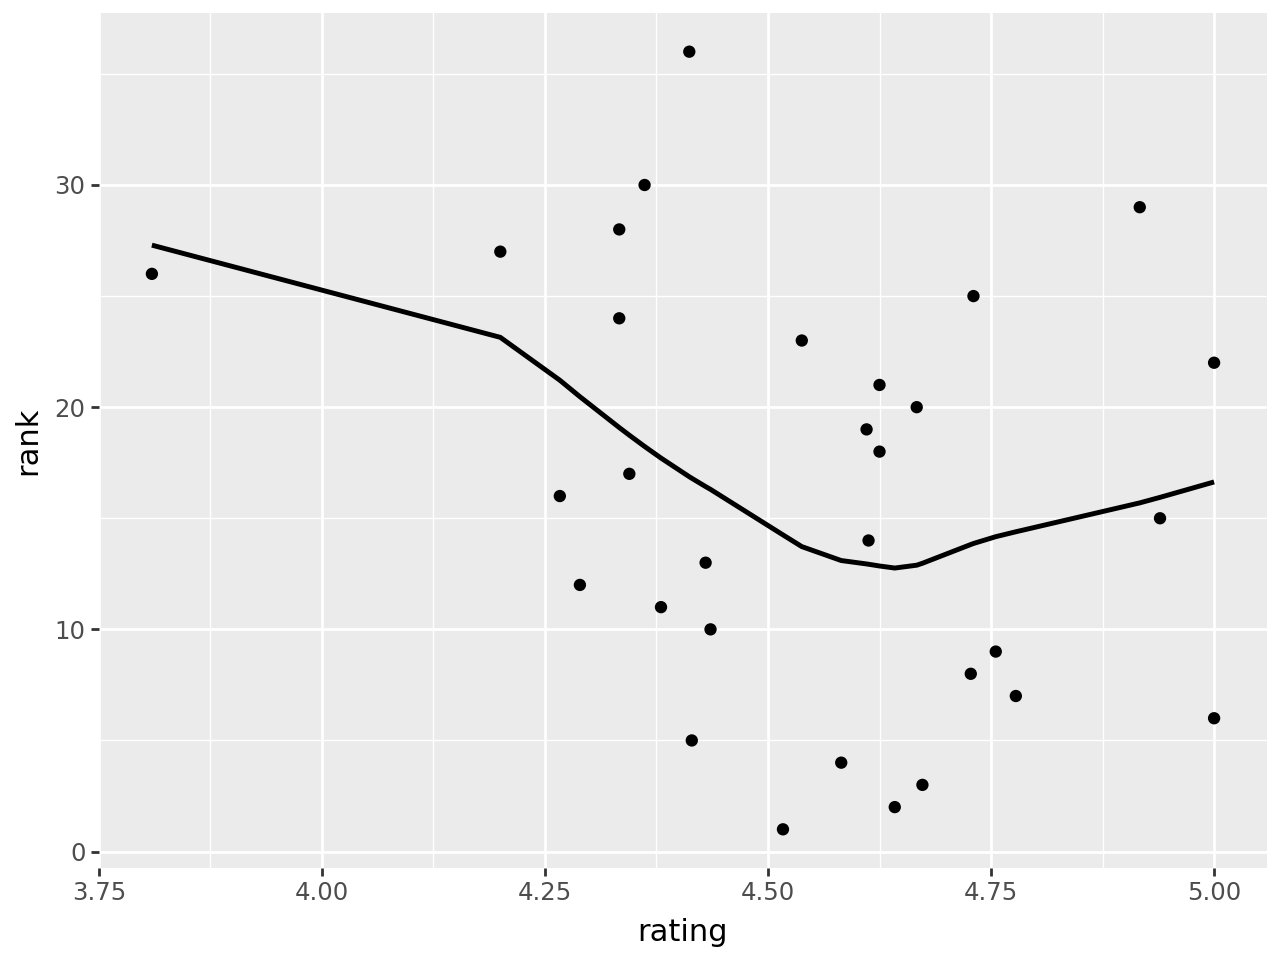

In [111]:
# let's plot the price and rating of the products with plotnine
(ggplot(df, aes(x='rating', y='rank')) # Creating a plot with price on the x-axis and rating on the y-axis
 + geom_point() # Adding points to the plot
    + stat_smooth() 
         # Adding a smoothed line to the plot
)

Visually there's little evidence for it.

Let's also try looking at the relationship between price and rank - are more expensive products worse selling?

We can do this with plotnine, but let's try making an interactive chart with another module `altair`:

In [113]:
chart = alt.Chart(df).mark_image(width=45, height=45, opacity=0.7).encode(
    x='rank:O',
    y='price:Q',
    url='image',
    tooltip=[
        'name', 'price', 'rating'
        ]
) # Creating an interactive scatter plot of the products using Altair

# some extra formatting, you can ignore, change or remove this
chart = chart.properties(
    background='rgb(239,239,239)',
    width=600,
    height=400,
    title=alt.TitleParams(
        "M&S Plants",
        fontSize = 16,
        subtitle="Price vs Best-Seller Rank",
        anchor="start"
    )
).configure_axis(grid=False).configure_axisY(labelExpr="'£'+datum.value").interactive() #  # Adding some formatting to the chart

chart.display()

alt.Chart(...)

Here, we see that the most expensive products (>£40) are usually among the worst selling products but that this possible relationship doesn't hold across the sample.

In [ ]:
df.head()

,name,price,rating,url,image,rank
0,Rose Trough,25,4.5168,http://www.marksandspencer.com/yellow-rose-tro...,https://assets.digitalcontent.marksandspencer....,1
1,Oriental Lily,28,4.6421,http://www.marksandspencer.com/oriental-lily/p...,https://assets.digitalcontent.marksandspencer....,2
2,Yellow Miniature Phalaenopsis Orchid in Cerami...,20,4.6731,http://www.marksandspencer.com/yellow-miniatur...,https://assets.digitalcontent.marksandspencer....,3
3,Rose Plant with Marc De Champagne Truffles,30,4.5821,http://www.marksandspencer.com/rose-plant-with...,https://assets.digitalcontent.marksandspencer....,4
4,Spring Flowering Basket,35,4.4146,http://www.marksandspencer.com/summer-flowerin...,https://assets.digitalcontent.marksandspencer....,5


In [ ]:
df.url.iloc[-1]

'http://www.marksandspencer.com/white-hydrangea-tin/p/flp60502976#intid=pid_pg1pip44g2r18c2'

## Extension: Image analysis

We have some beautiful flowers of different colours.

</br></br> Can we use the images to classify them by colour?

Let's:

1. Download the images
2. Use Kmeans to extract the dominant colours
3. Assign a colour to each product, by comparing the dominant colours to a list of known colours
4. Visualise

</br></br> Let's start by downloading the images.

In [114]:
image_data = []

os.makedirs('images', exist_ok=True) # Creating a directory to store the images
for i, row in tqdm(df.iterrows()): # Looping through the rows of the DataFrame
    img_data = requests.get(row['image']).content # Fetching the image data
    file_name = row['image'].split('/')[-1] # Getting the file name from the URL
    with open(f'images/{file_name}.jpg', 'wb') as f: # Writing the image data to a file
        f.write(img_data)
    time.sleep(0.25) 

31it [00:09,  3.25it/s]


And get the dominant colours via K-means

In [142]:
image_path = "images/SD_FD_F44A_29414529_NC_X_EC_90.jpg"
image = Image.open(image_path)

pixels = np.array(image).reshape(-1,3)
pixels[:5]

array([[13, 36, 28],
       [13, 36, 28],
       [13, 36, 28],
       [13, 36, 28],
       [13, 36, 28]], dtype=uint8)

In [126]:
def get_dominant_color_kmeans(image_path, k=3):
    image = Image.open(image_path)
    image = image.resize((50, 50))  # Reduce size to speed up processing
    pixels = np.array(image).reshape(-1, 3)  # Convert to RGB
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pixels)
    # reject v dark colours - they're the background
    colour_clusters = kmeans.cluster_centers_.astype(int)
    colour_clusters = colour_clusters[colour_clusters.sum(axis=1) > 100]  
    return colour_clusters[0]

df['image_path'] = df['image'].apply(lambda x: f'images/{x.split("/")[-1]}.jpg') # Adding a column with the path to the image file
df['dominant_color'] = df['image_path'].apply(get_dominant_color_kmeans) # Adding a column with the dominant color of the image

In [127]:
def display_clusters(cluster_centers):
    cluster_centers = np.array(cluster_centers, dtype=int)  # Ensure integer values

    plt.figure(figsize=(len(cluster_centers), 1))
    
    for i, color in enumerate(cluster_centers):
        plt.fill_between([i, i + 1], 0, 1, color=np.array(color) / 255)  # Normalize RGB to [0,1]

    plt.xlim(0, len(cluster_centers))
    plt.ylim(0, 1)
    plt.axis("off")  # Hide axes
    plt.show()

Let's take a look at all our products with their dominant colours.

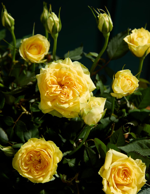

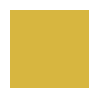

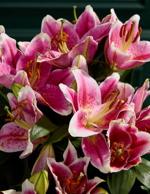

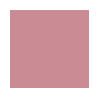

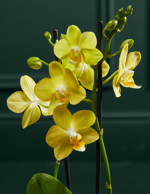

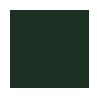

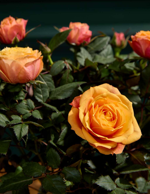

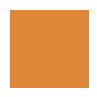

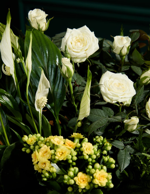

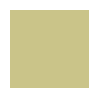

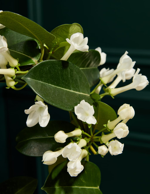

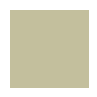

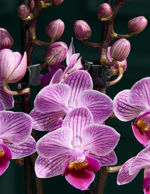

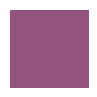

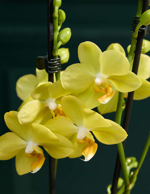

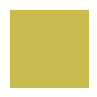

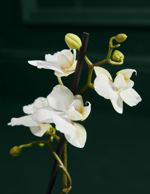

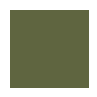

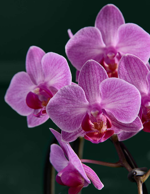

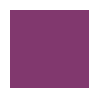

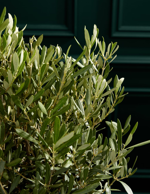

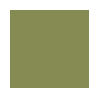

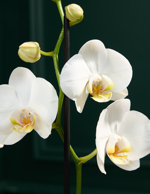

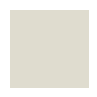

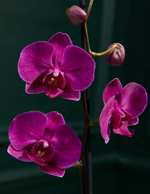

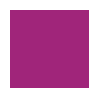

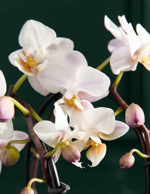

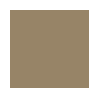

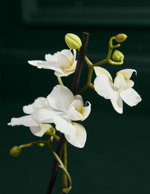

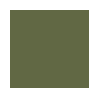

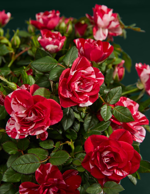

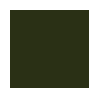

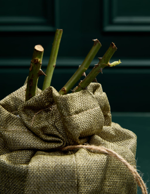

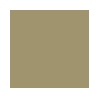

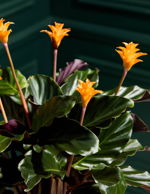

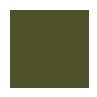

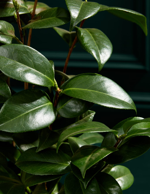

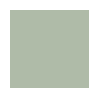

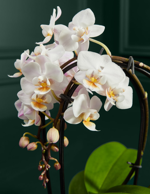

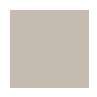

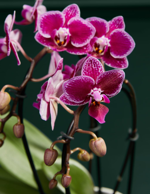

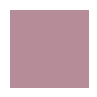

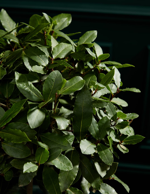

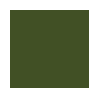

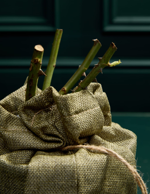

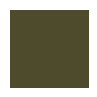

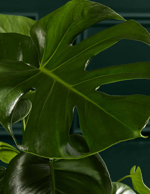

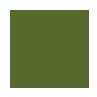

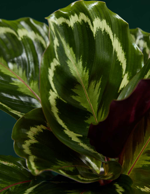

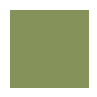

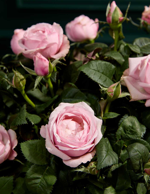

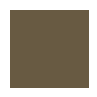

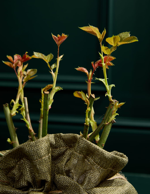

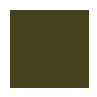

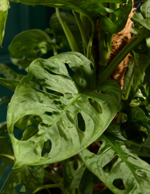

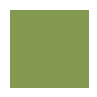

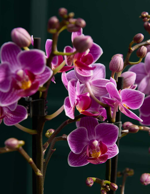

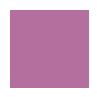

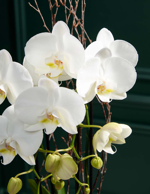

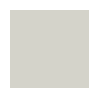

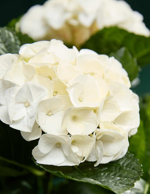

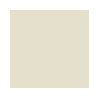

In [128]:
# loop over the images and dominant colors
for img_path, dominant_color in zip(df['image_path'], df['dominant_color']):
    image = Image.open(img_path)
    display(image.resize((150, int(150 * image.height / image.width)))) # Displaying the image with a maximum width of 150
    display_clusters([dominant_color]) # Displaying the dominant color of the image


And asign dominant colours by comparing the dominant colour to a list of known colours.

In [129]:
colour_categories = {
    "cream": np.array([223, 220, 207]),  # Soft beige/cream
    "dark green": np.array([27, 48, 34]),  # Deep green
    "purple": np.array([160, 37, 122]),  # A strong purple
    "yellow": np.array([215, 182, 64])  # Warm yellow
}

def find_closest_colour_category(colour):
    colour = np.array(colour)
    distances = {name: np.linalg.norm(colour - rgb) for name, rgb in colour_categories.items()}
    return min(distances, key=distances.get)

df['colour_category'] = df['dominant_color'].apply(find_closest_colour_category) # Adding a column with the closest colour category
df['rank_in_colour'] = df.groupby('colour_category')['rank'].rank() # Adding a column with the rank of the product within its colour category - this doesn't actually mean anything - it's just for our chart below

In [130]:
alt.Chart(df).mark_image(
    width=45,
    height=45,
    opacity=0.7
).encode(
    x=alt.X("colour_category:N", title="Colour Category"),
    y=alt.Y("rank_in_colour:Q", title=""),
    url=alt.Url("image:N", title="Product URL"),
).properties(
    title="M&S Plants",
    width=600,
    height=400
)
    

alt.Chart(...)

# Where from here?

Today, we've scraped the products from one page of products from a retailer website. IF you want to continue this project or expand your skills, here are some options:

1. **Scraping Other Pages**: Turn the scraping code above into a method and call it with the URLs of other results. 
2. **Scraping the whole site**: As an advanced extension, also try automating the building of this list by scraping the page menu bar. Then scrape every category.
3. **Collect and compare prices**: Run this code on a few dates, see how prices change. Flower prices might be elevated in the UK with Mothers' day in a few days - do they fall after?

# Extension: Scraping More

At present, we're scraping one page for ~46 products.

This is a good start but it'd be more useful to have a tool that can scrape all the products in a page - or even the whole category or website.

## A Method to Scrape a Page

Above, to scrape a page, we:

1. Find all the product divs
2. Find the accesibility labels
3. Extract product information from accesibility labels

Let's move this all to a function

#### Task: Complete scrape_one_page

Look at the code earlier on ('Finding more product information') and incorporate it into the function below in order to scrape one page. See the `TODO` labels for guidance. 

In [131]:
def scrape_one_page(url):
    """
    (str) -> pd.DataFrame
    Given a URL for a page of products, scrape the product details and return a DataFrame
    """
    print(f"Scraping {url}") # Printing the URL we're scraping
    req = requests.get(url) # Making a request for the M&S plants page

    # TODO: Make a soup object from the request text
    soup = BeautifulSoup(req.text, 'html.parser') # Parsing the HTML using BeautifulSoup and the built-in HTML parser

    products = [] # Creating an empty list to store the product details
    product_divs = soup.find_all('div', attrs={'data-tagg': lambda x: x and "product-card" in x}) # Using a lambda function to find all divs with data-tagg attribute that contain "product-card" and potentially other values
    for i, product_div in enumerate(product_divs): # Looping through the first 10 product divs
        a_tag = product_div.find('a') # Finding the first a tag in the product div 
        aria_label = a_tag['aria-label'] #Get the value of the aria-label attribute of the a tag

        product_details = product_details_from_label(aria_label) # Using the function to get the product details from the aria-label

        # extract the product link from the a tag
        product_details['url'] = a_tag['href'] # Getting the value of the href attribute of the a tag
        product_details['url'] = "http://www.marksandspencer.com" + product_details['url'] # Adding the base URL to the product URL

        # extract the image link from the a tag
        img_tags = a_tag.find_all('img') # Finding the first img tag in the a tag
        product_details['image'] = img_tags[-1]['src'] # Getting the value of the src attribute of the img tag

        # add the rank of the product
        product_details['rank'] = i + 1 # Adding the rank of the product

        products.append(product_details) # Appending the product details to the list of products

    return pd.DataFrame(products) # Creating a DataFrame from the list of products


Let's try the function out on another category:

In [132]:
url = "https://www.marksandspencer.com/l/gifts/food-and-drink-gifts?sort=best_seller+desc&page=10"
page_products = scrape_one_page(url) # Using the function to scrape the first page of products
page_products.head() # let's take a peek at the first 5 products

Scraping https://www.marksandspencer.com/l/gifts/food-and-drink-gifts?sort=best_seller+desc&page=10


,name,price,url,image,rank,rating
0,Mother's Day Breakfast in Bed Hamper,55,http://www.marksandspencer.com/mother-s-day-br...,https://assets.digitalcontent.marksandspencer....,1,NaN
1,Afternoon Tea Letterbox Gift,20,http://www.marksandspencer.com/afternoon-tea-l...,https://assets.digitalcontent.marksandspencer....,2,4.7615
2,Blush Rose Abundance Bouquet with Swiss Chocol...,45,http://www.marksandspencer.com/blush-rose-abun...,https://assets.digitalcontent.marksandspencer....,3,4.5316
3,Pop the Prosecco Gift Box,35,http://www.marksandspencer.com/pop-the-prosecc...,https://assets.digitalcontent.marksandspencer....,4,4.8343
4,Afternoon Tea Gift Box,35,http://www.marksandspencer.com/afternoon-tea-g...,https://assets.digitalcontent.marksandspencer....,5,4.6235


#### Task: Scraping a Whole Category

It would be good to not have to specify every page `url`. Let's write a function where we can specify just a category and then scrape it.

In [133]:
def scrape_category(category_route):
    """
    (str) -> pd.DataFrame
    Given a category route, scrape all the products from all the pages and return a DataFrame
    """
    page_number = 1 # Starting at page 1

    # Scrape the first page of products
    url = f"{category_route}?page={page_number}&sort=best_seller+desc" # Creating the URL for the current page
    products_df = scrape_one_page(url) # Using the function to scrape the current page of products
    unique_product_count = len(products_df.drop_duplicates(subset=['name'])) # Counting the number of unique products - we'll stop scraping when we're not collecting any more unique products

    while True: # Looping forever until we're not collecting any more products
        url = f"{category_route}?page={page_number}&sort=best_seller+desc" # Creating the URL for the current page
        page_products = scrape_one_page(url) # Using the function to scrape the current page of products

        # merge the new products with the old ones
        products_df = pd.concat([products_df, page_products])

        # if the number of unique products has not changed, we're done
        if len(products_df.drop_duplicates(subset=['name'])) == unique_product_count: 
            break
        
        page_number += 1 # Incrementing the page number
        time.sleep(1)
    return products_df # Concatenating the list of products into a single DataFrame

In [134]:
category_route = "http://www.marksandspencer.com/l/gifts/food-and-drink-gifts"
food_and_drink_gifts = scrape_category(category_route) # Using the function to scrape the category

Scraping http://www.marksandspencer.com/l/gifts/food-and-drink-gifts?page=1&sort=best_seller+desc
Scraping http://www.marksandspencer.com/l/gifts/food-and-drink-gifts?page=1&sort=best_seller+desc


## Advanced Extension Task: Identifying Categories to Scrape

What is we didn't even have to identify the categories ourselves?

The M&S website has a list of brands in its navigation bar. Can we extract these categories?

<img src="https://raw.githubusercontent.com/FM-ds/ScrapingWorkshop/main/notebook_images/brands.png" width="600">



In [135]:
# Find all the links on the page
soup = BeautifulSoup(requests.get("https://www.marksandspencer.com").text, 'html.parser') # Parsing the HTML using BeautifulSoup and the built-in HTML parser
links = soup.find_all('a') # Finding all the links on the page
links[:5]


[<a class="media-0_label__6_MaV skip-link_wrapper__ec15Q link_link__EtgPi link_primary__hQmpK link_inverse__7Tg_v" href="#main-content">Skip to content<span aria-label="" class="render-svg_svg__ah__C render-svg_coloured__G_eK5 link_arrowIcon__PjwUv" role="presentation" style="--render-svg-icon-url:url('https://static.marksandspencer.com/icons/svgs/ArrowRight-v3-1.svg?key=v3');--render-svg-icon-color:#222222;--render-svg-height:24px;--render-svg-width:24px;--render-svg-background-size:24px"></span></a>,
 <a aria-label="Mother’s Day gift ideas" class="media-0_textSm__Q52Mz media-0_noTextDecoration__I3GOV site-stripe_textColor__lwIHt site-stripe_slideItem__r1Osm media-0_strong__aXigV" data-slide="true" href="https://www.marksandspencer.com/l/mothers-day/mothers-day-gifts#intid=sitestripe_1_mother%e2%80%99s%20day%20gift%20ideas">Mother’s Day gift ideas</a>,
 <a aria-label="Skincare 101 with Clinique, live!" class="media-0_textSm__Q52Mz media-0_noTextDecoration__I3GOV site-stripe_textColor_

In [136]:
# find only the links with the form https://www.marksandspencer.com/l/brands
brand__links = [link['href'] for link in links if link['href'].startswith("https://www.marksandspencer.com/l/brands")] # Finding only the links with the form https://www.marksandspencer.com/l/brands
brand__links[:5]


KeyError: 'href'

Now let's try scraping the first five of these:

In [ ]:
all_products_dfs = []

for brand_url in brand__links[:5]: # Looping through the first 5 brand URLs
    print(brand_url) # Printing each brand URL

    # scrape the category
    category_df = scrape_category(brand_url) # Using the function to scrape the category
    category_df['category'] = brand_url.replace("https://www.marksandspencer.com/l/brands/", "").split("#")[0]

    all_products_dfs.append(category_df) # Appending the category DataFrame to the list of all category DataFrames
    all_products_df = pd.concat(all_products_dfs) # Concatenating the list of category DataFrames into a single DataFrame

    time.sleep(1) # Sleeping for 1 second


https://www.marksandspencer.com/l/brands/lk-bennett#intid=gnav_Women_Brands_LK-Bennett
Scraping https://www.marksandspencer.com/l/brands/lk-bennett#intid=gnav_Women_Brands_LK-Bennett?page=1&sort=best_seller+desc
Scraping https://www.marksandspencer.com/l/brands/lk-bennett#intid=gnav_Women_Brands_LK-Bennett?page=1&sort=best_seller+desc
https://www.marksandspencer.com/l/brands/puma#intid=gnav_Women_Brands_PUMA
Scraping https://www.marksandspencer.com/l/brands/puma#intid=gnav_Women_Brands_PUMA?page=1&sort=best_seller+desc
Scraping https://www.marksandspencer.com/l/brands/puma#intid=gnav_Women_Brands_PUMA?page=1&sort=best_seller+desc
https://www.marksandspencer.com/l/brands/reebok/womens#intid=gnav_Women_Brands_Reebok
Scraping https://www.marksandspencer.com/l/brands/reebok/womens#intid=gnav_Women_Brands_Reebok?page=1&sort=best_seller+desc
Scraping https://www.marksandspencer.com/l/brands/reebok/womens#intid=gnav_Women_Brands_Reebok?page=1&sort=best_seller+desc
https://www.marksandspencer.

In [ ]:
all_products = pd.concat(all_products_dfs) # Concatenating the list of all category DataFrames into a single DataFrame
all_products

,name,price,url,image,rank,category,details,rating
0,Printed Collared Puff Sleeve Peplum Blouse,199,http://www.marksandspencer.com/printed-collare...,https://asset1.cxnmarksandspencer.com/is/image...,1,lk-bennett,NaN,NaN
1,Printed Trousers,199,http://www.marksandspencer.com/printed-trouser...,https://asset1.cxnmarksandspencer.com/is/image...,2,lk-bennett,NaN,NaN
2,Pure Cotton Collared Midi Shirt Dress,259,http://www.marksandspencer.com/pure-cotton-col...,https://asset1.cxnmarksandspencer.com/is/image...,3,lk-bennett,NaN,NaN
3,Tweed Collarless Cropped Jacket,329,http://www.marksandspencer.com/tweed-collarles...,https://asset1.cxnmarksandspencer.com/is/image...,4,lk-bennett,NaN,NaN
4,Pure Cotton Collared Cropped Jacket,299,http://www.marksandspencer.com/pure-cotton-col...,https://asset1.cxnmarksandspencer.com/is/image...,5,lk-bennett,NaN,NaN
...,...,...,...,...,...,...,...,...
43,Elevated Cotton Rich Wide Leg Joggers,42.50 - £66.50,http://www.marksandspencer.com/elevated-cotton...,https://asset1.cxnmarksandspencer.com/is/image...,44,the-sports-edit,The Sports Edit,2.67
44,Chill Athletic Crew Neck Racer Back Vest Top,27,http://www.marksandspencer.com/chill-athletic-...,https://asset1.cxnmarksandspencer.com/is/image...,45,the-sports-edit,The Sports Edit,NaN
45,Classic Leather Lace Up Trainers,80,http://www.marksandspencer.com/classic-leather...,https://asset1.cxnmarksandspencer.com/is/image...,46,the-sports-edit,The Sports Edit,4.83
46,Arahi 6 Trainers,129 - £130,http://www.marksandspencer.com/lace-up-trainer...,https://asset1.cxnmarksandspencer.com/is/image...,47,the-sports-edit,The Sports Edit,4.31


It works! In ~12 seconds, we scraped 460 products.